In [2]:
import subprocess
import pandas as pd

In [117]:
import shutil
import urllib.request as request
from contextlib import closing
from urllib.error import URLError
import os


import sys
import time
import urllib
import subprocess

url = [("http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz")]
outpath = "./data/vcf/"

### FROM BLOG: https://blog.shichao.io/2012/10/04/progress_speed_indicator_for_urlretrieve_in_python.html
# adds download progress bar to urlretrieve
def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                    (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()
###

def get_biodata(urls, outdir):
    """ Feed config file with array of urls, and directory to save at.
    """
    files_downloaded = []
    for url in urls:
        files_downloaded.append(get_biofile(url, outdir))
    return files_downloaded

        
# in the future maybe specify number, chromosome, population, etc.
def get_biofile(url, outdir):
    """ Helper to specifically download one file from url to out directory.
    """
    filename = url.split('/')[-1]
    
    if not os.path.exists(outdir):
        os.mkdir(outdir)

    fullpath = os.path.join(outdir, filename) 

    print("Downloading...")
    urllib.request.urlretrieve(url, fullpath, reporthook) # downloads to fullpath
    
    for_check_zip = '.gz'
    if url.endswith(for_check_zip):
        print()
        print("Unzipping")
        subprocess.run(["unzip",fullpath])
        
    return fullpath        


In [120]:
url = [("http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz")]
outpath = "../data/vcf/"
# get_biodata(url, outpath)

In [93]:
def run_process(command, print_out=1):
    p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    outputs = []
    if print_out:
        for outline in p.stdout.readlines():
            print(outline.strip())
            outputs.append(outline.strip().decode("utf-8"))
        
    retval = p.wait()
    return outputs

def filter_vcf(fp, out_path, out_prefix, MAF='0.1'):
    """ ex: fp = '/datasets/dsc180a-wi20-public/Genome/vcf/ALL.chr22.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz'
    out_path = '~/'DSC180A Project'/data/vcf/filtered/'
    out_prefix = 'chr22filtered'
    MAF = '0.1'
    """
    from pathlib import Path
    Path(out_path).mkdir(parents=True, exist_ok=True)
    
    cmd = ["cd "+ out_path + "; plink2 --vcf " + fp + " --maf " + str(MAF) + " --indep-pairwise 50 10 0.1 --out "+ out_prefix]
    run_process(cmd)
    return out_path + out_prefix
    
def make_pca(fp, prune_path, pca_out_path, out_prefix):
    """ fp = '/datasets/dsc180a-wi20-public/Genome/vcf/ALL.chr22.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz'
    prune_path = '~/'DSC180A Project'/data/vcf/filtered/chr22filtered.prune.in'
    
    """
    pca_file_name = pca_out_path + out_prefix + '_pca'
    cmd = 'plink2 --vcf ' + fp + ' --extract ' + prune_path + ' --make-bed --pca --out ' + pca_file_name
    run_process(cmd)
    return pca_file_name
    
def plot_from_pca(pca_file_name):
    
    eigvec = pd.read_table(pca_file_name + ".eigenvec", delimiter=' ', header = None)
    eigval = pd.read_table(pca_file_name + ".eigenval", delimiter=' ', header = None)

    to_plot = eigvec.copy()
    to_plot[0] = to_plot[0].apply(lambda x: x[:2])
    to_plot[1] = to_plot[1].apply(lambda x: x[:2])

    ax = to_plot.plot.scatter(x=2, y=3, label='0', legend=False)

    ax.set_title('PCA')
    ax.set_ylabel('PC 2')
    ax.set_xlabel('PC 1')

    perc_var = (eigval[:16])/eigval[0].sum()*100

    ax2 = perc_var.plot(kind='bar', legend=False)
    ax2.set_title('Percent Variance Explained by PC')

In [59]:
fp = '/datasets/dsc180a-wi20-public/Genome/vcf/ALL.chr22.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz'
out_path = "~/'DSC180A Project'/data/vcf/filtered/"
out_prefix = 'chr22filtered'
MAF = '0.05'
filter_vcf(fp, out_path, out_prefix, MAF)

b'PLINK v1.90p 64-bit (25 Mar 2016)          https://www.cog-genomics.org/plink2'
b'(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3'
b'Logging to chr22filtered.log.'
b'Options in effect:'
b'--indep-pairwise 50 10 0.1'
b'--maf 0.05'
b'--out chr22filtered'
b'--vcf /datasets/dsc180a-wi20-public/Genome/vcf/ALL.chr22.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz'
b''
b'385411 MB RAM detected; reserving 192705 MB for main workspace.'
b'--vcf: 1k variants complete.\r--vcf: 2k variants complete.\r--vcf: 3k variants complete.\r--vcf: 4k variants complete.\r--vcf: 5k variants complete.\r--vcf: 6k variants complete.\r--vcf: 7k variants complete.\r--vcf: 8k variants complete.\r--vcf: 9k variants complete.\r--vcf: 10k variants complete.\r--vcf: 11k variants complete.\r--vcf: 12k variants complete.\r--vcf: 13k variants complete.\r--vcf: 14k variants complete.\r--vcf: 15k variants complete.\r--vcf: 16k variants complete.\r--vcf: 17k variants complete.\r--vcf: 18

In [128]:
copy_test_file = "cp /datasets/dsc180a-wi20-public/Genome/vcf/sample/chr22_test.vcf.gz ~/'DSC180A Project'/test/"

run_process(copy_test_file)

[]

In [127]:
os.getcwd()

'/home/psheurpu/DSC180A Project/notebooks'

In [122]:
check_files = ['cd /datasets/dsc180a-wi20-public/Genome/vcf/sample; ls']

copy_test_file = "cp /datasets/dsc180a-wi20-public/Genome/vcf/ALL.chr22.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz* ~/'DSC180A Project'/data/vcf/"

# vcf_to_bcf = '''for chr in {1..22}; do
#     bcftools norm -m-any --check-ref w -f human_g1k_v37.fasta \
#       ALL.chr'${chr}'.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz | \

#       bcftools annotate -x ID -I +'%CHROM:%POS:%REF:%ALT' | \

#         bcftools norm -Ob --rm-dup both \
#           > ALL.chr'${chr}'.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.bcf ;

#     bcftools index ALL.chr'${chr}'.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.bcf ;
# done'''


fp = '/datasets/dsc180a-wi20-public/Genome/vcf/ALL.chr22.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz'
out_path = 'chr22'

# ['gatk', 'FilterVcf', '--INPUT', 'data/temp/merged.vcf', '--OUTPUT', 'data/temp/filtered.vcf']


args1 = ["cd ~/'DSC180A Project'/data/vcf/filtered/; plink2 --vcf " + fp + " --maf " + MAF + " --indep-pairwise 50 10 0.1 --out "+ out_path]

# prune_fp = './vcf/filtered/chr22.prune.in'

# outdir = 'chr22pc'

# args2 = ['plink2', '--vcf', fp, '--extract', prune_fp, '--make-bed', '--pca', '--out', outdir]

# run_process(check_files)
# run_process(copy_test_file)
run_process(check_files)

b'chr22_test.vcf.gz'


['chr22_test.vcf.gz']

In [66]:
"~/'DSC180A Project'/data/vcf/ALL.chr21.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz"

"~/'DSC180A Project'/data/vcf/ALL.chr21.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz"

In [27]:
# import zipfile
# for zips in vcf_files:
#     with zipfile.ZipFile(zips, 'r') as zip_ref:
#         zip_ref.extractall("~/'DSC180A Project'/data/vcf/")
        
# copy_test_file = "cp /datasets/dsc180a-wi20-public/Genome/vcf/ALL.chr22.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz* ~/'DSC180A Project'/data/vcf/"
# run_process(copy_test_file)
# copy_test_file = "cp /datasets/dsc180a-wi20-public/Genome/vcf/ALL.chr21.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz* ~/'DSC180A Project'/data/vcf/"
# run_process(copy_test_file)


to_unzip = ["~/'DSC180A Project'/data/vcf/ALL.chr21.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz",
           "~/'DSC180A Project'/data/vcf/ALL.chr22.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz"]

for zips in to_unzip:
    run_process("gunzip -f "+ zips)

In [ ]:
# vcf_list = 'cd /datasets/dsc180a-wi20-public/Genome/vcf; ls'

# # get all dataset chromosome vcf's to merge
# vcf_files = run_process(vcf_list)
# vcf_files = ['/datasets/dsc180a-wi20-public/Genome/vcf/' + s for s in vcf_files]

# vcf_files = [i for i in vcf_files if (('vcf.gz' in i) & ('.tbi' not in i))] 


# for filename in vcf_files:
#     pop_list_command = "cd ~/'DSC180A Project'/data/vcf/filtered/; echo "+ filename + " >> toMerge.list"
#     run_process(pop_list_command)
    
# # "cd /datasets/dsc180a-wi20-public/Genome/vcf; find . -name '*.vcf.gz' | grep -e 'Pruned' > ForMerge.list ;"

# # args21 = "cd ~/'DSC180A Project'/data/vcf/filtered/; gatk MergeVcfs --INPUT -I toMerge.list --OUTPUT data/vcf/merged.vcf"
# args21 = "gatk MergeVcfs --INPUT ~/'DSC180A Project'/data/vcf/filtered/toMerge.list --OUTPUT output_variants.vcf.gz"

# # have to delete tomerge.list before running

In [58]:
# args21 = "gatk MergeVcfs -I ~/'DSC180A Project'/data/vcf/ALL.chr21.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf \
# -I ~/'DSC180A Project'/data/vcf/ALL.chr22.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf \
# --OUTPUT output_variants.vcf"
# run_process(args21)

In [32]:
# eigval = pd.read_table('chr22pc.eigenval', header = None)
# eigval.head()

In [99]:
pca_file_name

"~/'DSC180A Project'/data/pca/chr22filtered_pca"

In [68]:
prune = "~/'DSC180A Project'/data/vcf/filtered/chr22filtered"

fp = '/datasets/dsc180a-wi20-public/Genome/vcf/ALL.chr22.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz'
fp = "~/'DSC180A Project'/data/vcf/ALL.chr22.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz"
pca_out_path = "~/'DSC180A Project'/data/pca/"

out_path = "~/'DSC180A Project'/data/vcf/filtered/"
out_prefix = 'chr22filtered'
MAF = '0.1'

# cmd = ['plink2', '--vcf', fp, '--extract', prune_fp, '--make-bed', '--pca', '--out', outdir]
pca_file_name = pca_out_path + out_prefix + '_pca'
cmd = 'plink2 --vcf ' + fp + ' --extract ' + out_path + out_prefix + '.prune.in --make-bed --pca --out ' + pca_file_name

run_process(cmd)




b'PLINK v1.90p 64-bit (25 Mar 2016)          https://www.cog-genomics.org/plink2'
b'(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3'
b'Logging to /home/psheurpu/DSC180A Project/data/pca/chr22filtered_pca.log.'
b'Options in effect:'
b'--extract /home/psheurpu/DSC180A Project/data/vcf/filtered/chr22filtered.prune.in'
b'--make-bed'
b'--out /home/psheurpu/DSC180A Project/data/pca/chr22filtered_pca'
b'--pca'
b'--vcf /home/psheurpu/DSC180A Project/data/vcf/ALL.chr22.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz'
b''
b'385411 MB RAM detected; reserving 192705 MB for main workspace.'
b'--vcf: 1k variants complete.\r--vcf: 2k variants complete.\r--vcf: 3k variants complete.\r--vcf: 4k variants complete.\r--vcf: 5k variants complete.\r--vcf: 6k variants complete.\r--vcf: 7k variants complete.\r--vcf: 8k variants complete.\r--vcf: 9k variants complete.\r--vcf: 10k variants complete.\r--vcf: 11k variants complete.\r--vcf: 12k variants complete.\r--vcf: 13k va

['PLINK v1.90p 64-bit (25 Mar 2016)          https://www.cog-genomics.org/plink2',
 '(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3',
 'Logging to /home/psheurpu/DSC180A Project/data/pca/chr22filtered_pca.log.',
 'Options in effect:',
 '--extract /home/psheurpu/DSC180A Project/data/vcf/filtered/chr22filtered.prune.in',
 '--make-bed',
 '--out /home/psheurpu/DSC180A Project/data/pca/chr22filtered_pca',
 '--pca',
 '--vcf /home/psheurpu/DSC180A Project/data/vcf/ALL.chr22.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz',
 '',
 '385411 MB RAM detected; reserving 192705 MB for main workspace.',
 '--vcf: 1k variants complete.\r--vcf: 2k variants complete.\r--vcf: 3k variants complete.\r--vcf: 4k variants complete.\r--vcf: 5k variants complete.\r--vcf: 6k variants complete.\r--vcf: 7k variants complete.\r--vcf: 8k variants complete.\r--vcf: 9k variants complete.\r--vcf: 10k variants complete.\r--vcf: 11k variants complete.\r--vcf: 12k variants complete.\r--

In [111]:
pca_file_name

"~/'DSC180A Project'/data/pca/chr22filtered_pca"

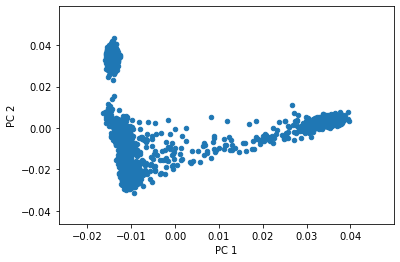

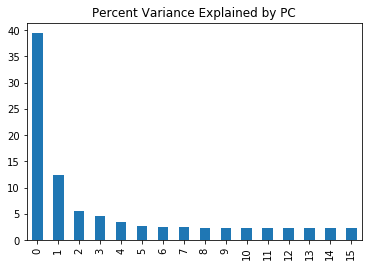

In [112]:
plot_from_pca("../data/pca/chr22filtered_pca")

In [97]:
run_process("cd ~/'DSC180A Project'/data/pca; ls")

b'chr22filtered_pca.bed'
b'chr22filtered_pca.bim'
b'chr22filtered_pca.eigenval'
b'chr22filtered_pca.eigenvec'
b'chr22filtered_pca.fam'
b'chr22filtered_pca.log'
b'chr22filtered_pca.nosex'


['chr22filtered_pca.bed',
 'chr22filtered_pca.bim',
 'chr22filtered_pca.eigenval',
 'chr22filtered_pca.eigenvec',
 'chr22filtered_pca.fam',
 'chr22filtered_pca.log',
 'chr22filtered_pca.nosex']

Text(0.5, 1.0, 'Percent Variance Explained by PC')

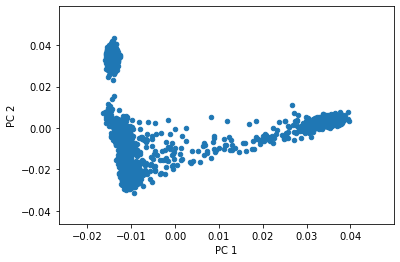

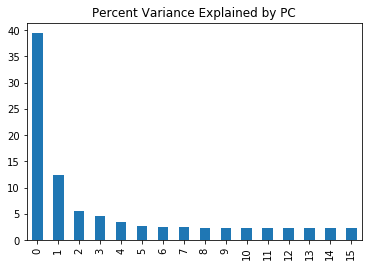

In [92]:

eigvec = pd.read_table("../data/pca/chr22filtered_pca.eigenvec", delimiter=' ', header = None)

eigval = pd.read_table("../data/pca/chr22filtered_pca.eigenval", delimiter=' ', header = None)

to_plot = eigvec.copy()
to_plot[0] = to_plot[0].apply(lambda x: x[:2])
to_plot[1] = to_plot[1].apply(lambda x: x[:2])

ax = to_plot.plot.scatter(x=2, y=3, label='0', legend=False)


ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')

perc_var = (eigval[:16])/eigval[0].sum()*100

ax2 = perc_var.plot(kind='bar', legend=False)
ax2.set_title('Percent Variance Explained by PC')

Text(0.5, 1.0, 'Percent Variance Explained by PC')

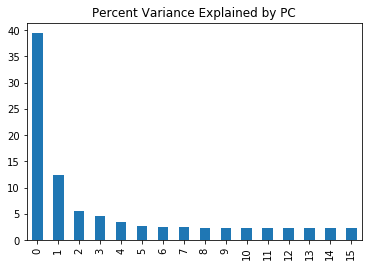

In [37]:
def main(targets):
    # grab small amount of data
    if 'data-test' in targets:
        cfg = load_params(TEST_PARAMS)
        get_data(**cfg)
        
    # make the data target
    if 'data' in targets:
        cfg = load_params(DATA_PARAMS)
        get_data(**cfg)

    # process and run data analysis
    if 'process' in targets:
        shutil.rmtree('data/temp',ignore_errors=True)
        shutil.rmtree('data/out',ignore_errors=True)
        shutil.rmtree('data/test',ignore_errors=True)

    

    return


# if __name__ == '__main__':
#     targets = sys.argv[1:]
#     main(targets)